<a href="https://colab.research.google.com/github/schwallergroup/ai4chem_course/blob/main/notebooks/03%20-%20Intro%20to%20Deep%20Learning/intro_to_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 3 tutorial - AI 4 Chemistry

## Table of content

1. Supervised deep learning.
2. Inductive biases.
3. Training neural networks.
4. Model selection and optimization.

In [ ]:
# Install all libraries
!pip install numpy scipy wandb

# Download all data
!mkdir data/
!wget https://raw.githubusercontent.com/schwallergroup/ai4chem_course/main/notebooks/02%20-%20Supervised%20Learning/data/esol.csv -O data/esol.csv

# 0. Relevant packages

### Pytorch
Based on the Torch library, PyTorch is one of the most popular deep learning frameworks for machine learning practitioners. We will learn to use PyTorch to do deep learning work. You can also browse the PyTorch [tutorials](https://pytorch.org/tutorials/) and [docs](https://pytorch.org/docs/stable/index.html) for additional details.

### Pytorch Lightning
PyTorch Lightning is the deep learning framework for professional AI researchers and machine learning engineers who need maximal flexibility without sacrificing performance at scale. You can also browse its [documentation](https://pytorch-lightning.readthedocs.io/en/stable/) for additional details.

### Pytorch Geometric (PyG)
PyG is a library built upon PyTorch to easily write and train Graph Neural Networks (GNNs) for a wide range of applications related to structured data. You can also browse its [documentation](https://pytorch-geometric.readthedocs.io/en/latest/) for additional details.


In [ ]:
# Install all libraries
# Pytorch and Pytorch Geometric have been installed
!pip install pytorch-lightning wandb

# 1. Supervised Deep Learning

From last session we should already be familiar with supervised learning: is a type of machine learning that involves training a model on a labeled dataset to learn the relationships between input and output data.

The models we saw so far are fairly easy and work well in some scenarios, but sometimes it's not enough. What to do in these cases?


<div align="center">
<img src="img/deeper_meme.png" width="500"/>
</div>

### Deep Learning
Deep learning is a subset of machine learning that involves training artificial neural networks to learn from data. Unlike traditional machine learning algorithms, which often rely on hand-crafted features and linear models, deep learning algorithms can automatically learn features and hierarchies of representations from raw data. This allows deep learning models to achieve state-of-the-art performance on a wide range of tasks in chemistry, like molecular property prediction, reaction prediction and retrosynthesis, among others.

#### Data: Let's go back to the [ESOL dataset](https://pubs.acs.org/doi/10.1021/ci034243x) from last week.
We will use this so we can compare our results with the previous models. We'll reuse last week's code for  data loading and preprocessing.


In [ ]:
import pandas as pd
from torch.utils.data import DataLoader

# load dataset from the CSV file
esol_df = pd.read_csv('data/esol.csv')

# Get NumPy arrays from DataFrame for the input and target
smiles = esol_df['smiles'].values
y = esol_df['log solubility (mol/L)'].values

# Here, we use molecular descriptors from RDKit, like molecular weight, number of valence electrons, maximum and minimum partial charge, etc.
from deepchem.feat import RDKitDescriptors
featurizer = RDKitDescriptors()
features = featurizer.featurize(smiles)
print(f"Number of generated molecular descriptors: {features.shape[1]}")

# Drop the features containing invalid values
import numpy as np
features = features[:, ~np.isnan(features).any(axis=0)]
print(f"Number of molecular descriptors without invalid values: {features.shape[1]}")

In [ ]:
# Data preprocessing
from sklearn.model_selection import train_test_split
X = features
# training data size : test data size = 0.8 : 0.2
# fixed seed using the random_state parameter, so it always has the same split.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=0)

# Create a validation set from the train set
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, train_size=0.8, random_state=0)


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)

# save original X
X_train_ori = X_train
X_test_ori = X_test
# transform data
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

## Neural Networks

Neural Networks are a type of machine learning model that is designed to simulate the behavior of the human brain.

<div align="center">
<img src="img/nn_image.png" width="500"/>
</div>

\
They consist of layers of interconnected nodes, and each node applies a `linear function` to its inputs. Non-linear activation functions are used to introduce `non-linearity` into the model, allowing it to learn more complex patterns in the data.

In [ ]:
import os
import torch
import wandb
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

## Creating a deep learning model.

Creating DL models is fairly easy nowadays, specially thanks to libraries like [Pytorch Lightning](https://pytorch-lightning.readthedocs.io/en/stable/index.html). They do most of the work for you, but they still alow you to have a lot of control over your models.

To use Pytorch Lightning, we first need to know about **classes**.


> Think of a class as a template or a set of instructions for creating objects with specific properties and behaviors. These objects are called instances of the class.

\
For example, let's say you want to make a program to represent dogs.

```python
class Dog:
    def __init__(self, name, color):
        self.name = name
        self.color = color
        
    def say_your_name(self):
        print(f"My name is {self.name}")
       
```

In this example, a dog has two attributes: `name` and `color`. It also has a method: `say_your_name`.

Now we can create as many dogs as we want! For example

```python
lassie = Dog(name = "Lassie", color = "White")
pluto = Dog(name = "Pluto", color = "Yellow")
```

And we can access their methods as follows:

```python
pluto.say_your_name()   # Output: "My name is Pluto"
```

---

<font color="#4caf50" size=4>
Now let's define a NeuralNetwork class.
</font>

- What is each part? 
    - `__init__` is where we specify the model architecture, 
       There are loads of layers (model parts) you can use,
       and it's all defined here.
        
    - `training step` is one of our model's methods. It updates the model paramters using an optimizer.
    
    - `configure_optimizers`, well, configures the optimizers 😅.\
       Here we define what optimizer to use, including learning rate.
    
    - `forward` specifices what the model should do when an input is given.

In [ ]:
class NeuralNetwork(pl.LightningModule):
    def __init__(self, input_sz, hidden_sz, train_data, valid_data, test_data, batch_size=254, lr=1e-3):
        super().__init__()
        self.lr = lr
        self.train_data = train_data
        self.valid_data = valid_data
        self.test_data = test_data
        self.batch_size = batch_size
        
        # Define all the components
        self.model = nn.Sequential(
            nn.Linear(input_sz, hidden_sz),
            nn.ReLU(),
            nn.Linear(hidden_sz, hidden_sz),
            nn.ReLU(),
            nn.Linear(hidden_sz, 1)
        )
        
    def training_step(self, batch, batch_idx):
        # Here we define the train loop.
        x, y = batch
        z = self.model(x)
        loss = F.mse_loss(z, y)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        # Define validation step. At the end of every epoch, this will be executed
        x, y = batch
        z = self.model(x)
        loss = F.mse_loss(z, y) ** 0.5  # report RMSE
        self.log("validation loss", loss)
        
    def test_step(self, batch, batch_idx):
        # What to do in test
        x, y = batch
        z = self.model(x)
        loss = F.mse_loss(z, y) ** 0.5  # report RMSE
        self.log("test loss", loss)

    def configure_optimizers(self):
        # Here we configure the optimization algorithm.
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.lr
        )
        return optimizer
    
    def forward(self, x):
        # Here we define what the NN does with its parts
        return self.model(x).flatten()
    
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size = self.batch_size)
    
    def val_dataloader(self):
        return DataLoader(self.valid_data, batch_size = self.batch_size)
    
    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size = self.batch_size)

### Dataset class

To use Lightning, we also need to create a `Dataset` class.\
It looks more complicated, but it actually allows a lot of flexibility in more complex scenarios! (so don't be daunted by this 😉)

In [ ]:
from torch.utils.data import Dataset

class ESOLDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        X_ = torch.as_tensor(self.X[idx].astype(np.float32))
        y_ = torch.as_tensor(self.y[idx].astype(np.float32).reshape(-1))
        
        return X_, y_
    
train_data = ESOLDataset(X_train, y_train)
valid_data = ESOLDataset(X_valid, y_valid)
test_data = ESOLDataset(X_test, y_test)

In [ ]:
# This will ask you to login to your wandb account

wandb.init(project="nn-solubility",
           config={
               "batch_size": 500,
               "learning_rate": 0.02,
               "hidden_size": 254,
               "max_epochs": 400
           })

In [ ]:
# Here we create an instance of our neural network.
# Play around with the hyperparameters!
nn_model = NeuralNetwork(
    input_sz = X.shape[1],
    hidden_sz = wandb.config["hidden_size"],
    train_data = train_data,
    valid_data = valid_data,
    test_data = test_data,
    lr = wandb.config["learning_rate"],
    batch_size=wandb.config["batch_size"]
)

# Define trainer: How we want to train the model
wandb_logger = WandbLogger()
trainer = pl.Trainer(
    max_epochs = wandb.config["max_epochs"],
    logger = wandb_logger
)

# Finally! Training a model :)
trainer.fit(
    model=nn_model,
)

# Now run test
trainer.test()
wandb.finish()

# Exercise:

Play with the hyperparameters, see what you get.

You may play around with `hidden_sz`, `batch_sz`, `max_epochs`, `lr`,\
or even modify the architecture of our neural network i.e. change the number of layers, activation function, etc.



In [ ]:
#############
# YOUR CODE #
#############

---

One of the promises of deep learning algorithms is that they can learn to `automatically extract features from the raw data`.\
However, so far we have used the same featurization methods as we used for the more basic models.

> Can our models directly take a molecule as input?

# 2. Inductive biases

**Inductive biases** are assumptions we make about the data, that help our models extract signal from it. These assumptions are encoded in the model's architecture.

For instance, when we (humans) look at images, we think differently than when we read a book, or than when we analyze a molecule. **Processing all these different types of data requires different ways of interpretation, and thus different assumptions about the data**.

When building models, we attempt to encode these inductive biases in our model's architecture so they know how to read and process the data.

### Introducing Graph Neural Networks
A natural way of representing molecules is as graphs. A graph is a collection of nodes (atoms) and edges (bonds). 

<div align="center">
<img src="img/Chloroquine-2D-molecular-graph.png" width="500"/>
</div>

Each node has some list of basic properties (think of a carbon atom, it has 6 electrons, it's electronic configuration is $1s^22s^22p^2$, etc.); however some properties change depending on the atomic environment (e.g. clearly a carbonyl C acts very differenly from a carbene). 

In the end, this is what we assume from the data:

> Molecules are formed by atoms connected by bonds, and each atom is influenced mostly by its closest neighbors.\
> Molecular properties are determined solely by the molecular graph.

This is what **we assume** and thus what **we tell our model**. The specific details of how to calculate the solubility of a molecule (or any other property), that's exactly what the model will try to learn from the data!

# 2. Graph neural network in chemistry

## 2.1 Graph representation

In [graph theory](https://en.wikipedia.org/wiki/Graph_theory), a graph $G=(V,E)$ is defined by a set of **nodes** (also called **vertices**) $V$ and a set of **edges** (also called **links**) $E$ between these vertices. More specifically:

- $V = \{ v_1, \: ..., \: v_n \}$, a set of nodes;
- $E \subseteq \{ (i,j) \: | \: i,j \in V,  \: i \neq j \}$, a set of edges representing connections between nodes.

If the edges of a graph have directions, the graph is called a directed graph, otherwise it is called an undirected graph.

<center width="100%" style="padding:10px"><img src="img/graphs.png" width="250px"></center>

In many cases we also have attribute or feature information associated with a graph:
- node features: $\mathbf{X} = [..., \: x_i, \: ...]^T \in \mathbb{R}^{|V| \times m}$, and $x_i \in \mathbb{R}^m$ denotes the feature of node $i$;
- edge features: $\mathbf{L} = [..., \: l_{i,j}, \: ...]^T \in \mathbb{R}^{|E| \times r}$, and $l_{i,j} \in \mathbb{R}^r$ denotes the feature of the edge between node $i$ and node $j$;
- graph features: $\mathbf{G} = (..., \: g_i, \: ...) \in \mathbb{R}^s$, and $g_i$ is the feature (or label) $i$ of the graph, which is usually the prediction target.

For instance, let's look at the following undirected graph with node features:

<center width="100%" style="padding:10px"><img src="img/graph_example.svg" width="250px"></center>

This graph has 4 nodes and 4 edges. The nodes are $V=\{1,2,3,4\}$, and edges $E=\{(1,2), (2,3), (2,4), (3,4)\}$. Note that for simplicity, we don't add mirrored pairs like $(2,1)$. And we have the following node features:

$$
\mathbf{X} = \begin{bmatrix}
    0 & 1 & 2\\
    1 & 0 & 1\\
    1 & 1 & 0\\
    3 & 1 & 4
\end{bmatrix}
$$

The **adjacency matrix** $A$ is a square matrix whose elements indicate whether pairs of nodes are adjacent, i.e. connected, or not. In the simplest case, $A_{ij}$ is 1 if there is a connection from node $i$ to $j$, and otherwise 0. For an undirected graph, keep in mind that $A$ is a symmetric matrix ($A_{ij}=A_{ji}$). For the example graph above, we have the following adjacency matrix:

$$
A = \begin{bmatrix}
    0 & 1 & 0 & 0\\
    1 & 0 & 1 & 1\\
    0 & 1 & 0 & 1\\
    0 & 1 & 1 & 0
\end{bmatrix}
$$

### Molecular graph
A [molecular graph](https://en.wikipedia.org/wiki/Molecular_graph) is a labeled graph whose nodes correspond to the atoms of the compound and edges correspond to chemical bonds. It also has node features (**atom features**), edge features (**bond features**) and graph labels (chemical properties of a molecule). Next, we demonstrate a simple example of building a molecular graph (undirected). In this example, we do not consider hydrogen atoms as nodes.

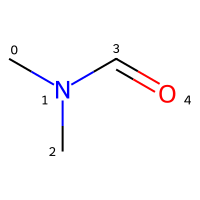

In [39]:
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

IPythonConsole.ipython_useSVG = True  # < use SVGs instead of PNGs
IPythonConsole.drawOptions.addAtomIndices = True  # adding indices for atoms
IPythonConsole.drawOptions.addBondIndices = False  # not adding indices for bonds
IPythonConsole.molSize = 200, 200

# N,N-dimethylformamide (DMF)
dmf_smiles = 'CN(C)C=O'
mol = MolFromSmiles(dmf_smiles)
# show molecular graph of DMF, atom indices = node indices
mol

### Atom feature

| feature | description |
| ---- | ----  |
| atom type  | atomic number |
| degree  | number of directly-bonded neighbor atoms, including H atoms |
| formal charge | integer electronic charge assigned to atom |
| hybridization | sp, sp2, sp3, sp3d, or sp3d2 |

In [31]:
ATOM_FEATURES = {
    'atom_type' : [1, 6, 7, 8, 9],  # elements: H, C, N, O, F
    'degree' : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 'misc'],
    'formal_charge' : [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 'misc'],
    'hybridization' : [
        'SP', 'SP2', 'SP3', 'SP3D', 'SP3D2', 'misc'
        ],
}

def get_atom_fv(atom):
    """
    Converts rdkit atom object to feature list of indices
    :param atom: rdkit atom object
    :return: list
    """
    atom_fv = [
        ATOM_FEATURES['atom_type'].index(atom.GetAtomicNum()),
        ATOM_FEATURES['degree'].index(atom.GetTotalDegree()),
        ATOM_FEATURES['formal_charge'].index(atom.GetFormalCharge()),
        ATOM_FEATURES['hybridization'].index(str(atom.GetHybridization())),
    ]
    return atom_fv

atom_fvs = [get_atom_fv(atom) for atom in mol.GetAtoms()]
atom_fvs

[[1, 4, 5, 2], [2, 3, 5, 1], [1, 4, 5, 2], [1, 3, 5, 1], [3, 1, 5, 1]]

### Bond feature

| feature | description |
| ---- | ----  |
| bond type  | single, double, triple, or aromatic |
| stereo | none, any, E/Z or cis/trans |
| conjugated  | whether the bond is conjugated |

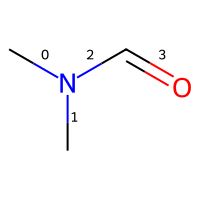

In [32]:
# Show indices of bonds
IPythonConsole.drawOptions.addAtomIndices = False  # not adding indices for atoms
IPythonConsole.drawOptions.addBondIndices = True  # adding indices for bonds
mol

In [33]:
BOND_FEATURES = {
    'bond_type' : [
        'SINGLE',
        'DOUBLE',
        'TRIPLE',
        'AROMATIC',
        'misc'
    ],
    'stereo': [
        'STEREONONE',
        'STEREOZ',
        'STEREOE',
        'STEREOCIS',
        'STEREOTRANS',
        'STEREOANY',
    ], 
    'conjugated': [False, True],
}

def get_bond_fv(bond):
    """
    Converts rdkit bond object to feature list of indices
    :param bond: rdkit bond object
    :return: list
    """
    bond_fv = [
        BOND_FEATURES['bond_type'].index(str(bond.GetBondType())),
        BOND_FEATURES['stereo'].index(str(bond.GetStereo())),
        BOND_FEATURES['conjugated'].index(bond.GetIsConjugated()),
    ]
    return bond_fv

bond_fvs = [get_bond_fv(bond) for bond in mol.GetBonds()]
bond_fvs

[[0, 0, 0], [0, 0, 0], [0, 0, 1], [1, 0, 1]]

### Adjacency matrix

### Edge index
In many cases, a list of paired node indices are used to describe edges rather than adjacency matrix. Here we use paired node indices (`edge_index`) with shape (2, num_edges) to define the edges in a graph.

$$
\mathbf{E} = \begin{bmatrix}
    ..., & i, & ..., & j, & ... \\
    ..., & j, & ..., & i, & ...
\end{bmatrix}
$$
Like, there has an edge between node $i$ and node $j$ (undirected graph).


In [35]:
edge_index0, edge_index1 = [], []

for bond in mol.GetBonds():
    i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
    edge_index0 += [i, j]
    edge_index1 += [j, i]

edge_index = [edge_index0, edge_index1]
edge_index

[[0, 1, 1, 2, 1, 3, 3, 4], [1, 0, 2, 1, 3, 1, 4, 3]]

### Molecular graph data

We set the density of DMF(0.944 $g/cm^3$) as the graph feature (label). Here we use [Data](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Data.html#torch_geometric.data.Data) class in `PyG` to create a graph data for DMF.

In [38]:
import torch
from torch_geometric.data import Data

# convert our data to tensors, which are used for model training
x = torch.tensor(atom_fvs, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long)
edge_attr = torch.tensor(bond_fvs, dtype=torch.float)
y = torch.tensor([0.944], dtype=torch.float)

dmf_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
dmf_data

/var/folders/zm/m5rfx32n1rb7rs1k0hpc39w40000gq/T/ipykernel_51973/1872422007.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edge_index, dtype=torch.long)


Data(x=[5, 4], edge_index=[2, 8], edge_attr=[4, 3], y=[1])

## 2.2 Graph Neural Network

A [graph neural network (GNN)](https://en.wikipedia.org/wiki/Graph_neural_network) is a class of artificial neural networks for processing data that can be represented as graphs. GNNs rely on [message passing methods](https://arxiv.org/abs/1704.01212), which means that nodes exchange information with the neighbors, and send "messages" to each other. Generally, GNNs operate in two phases: a **message passing** phase, which transmits information across the molecule to build a neural representation of the molecule, and a **readout** phase, which uses the final representation of the molecule to make predictions about the properties of interest.

### Message passing

Before looking at the math, we can try to visually understand how message passing works. The first step is that each node creates a `feature vector` that represents the `message` it wants to send to all its neighbors. In the second step, the messages are sent to the neighbors, so that a node receives one message per adjacent node. As shown in the figure below, after a message passing step, `node 1` can get the message from `node 2`, and `node 2` can get messages from `node 1`, `node 3` and `node 4`. The third step is that each node will aggregate all messages from neighbors and get a `message vector`. Then, the fourth step is that each node updates its `feature vector` based on its `message vector` and previous `feature vector`.

<center width="100%" style="padding:10px"><img src="img/graph_message_passing.svg" width="700px"></center>

Moreover, with the iteration of message passing, each node can obtain the feature vectors of more distant nodes and not limited to neighbors. As shown in the figure below, node `A` can get informations from node `E` and node `F`, which are not the neighbors of node `A`.

<center width="100%" style="padding:10px"><img src="img/messages.svg" width="700px"></center>

### Readout

In [ ]:
# Implementation of a GNN

In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import GRU

from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MLP, global_add_pool
from torch_geometric.nn import NNConv, Set2Set

class MPNN(pl.LightningModule):
    def __init__(self, hidden_dim, out_dim,
                 train_data, valid_data, test_data,
                 std, batch_size=32, lr=1e-3):
        super().__init__()
        self.std = std  # std of data's target
        self.train_data = train_data
        self.valid_data = valid_data
        self.test_data = test_data
        self.batch_size = batch_size
        self.lr = lr
        # Initial layers
        self.atom_emb = AtomEncoder(emb_dim=hidden_dim)
        self.bond_emb = BondEncoder(emb_dim=hidden_dim)
        # Message passing layers
        nn = MLP([hidden_dim, hidden_dim*2, hidden_dim*hidden_dim])
        self.conv = NNConv(hidden_dim, hidden_dim, nn, aggr='mean')
        self.gru = GRU(hidden_dim, hidden_dim)
        # Readout layers
        self.set2set = Set2Set(hidden_dim, processing_steps=3)
        self.mlp = MLP([hidden_dim*2, hidden_dim, out_dim])

    def forward(self, data, mode="train"):

        # Initialization
        x = self.atom_emb(data.x)
        h = x.unsqueeze(0)
        edge_attr = self.bond_emb(data.edge_attr)
        
        # Message passing
        for i in range(3):
            m = F.relu(self.conv(x, data.edge_index, edge_attr))
            x, h = self.gru(m.unsqueeze(0), h)
            x = x.squeeze(0)

        # Readout
        x = self.set2set(x, data.batch)
        x = self.mlp(x)

        return x
        
    def training_step(self, batch, batch_idx):
        # Here we define the train loop.
        out = self.forward(batch, mode="train")
        loss = F.mse_loss(out, batch.y)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        # Define validation step. At the end of every epoch, this will be executed
        out = self.forward(batch, mode="valid")
        loss = F.mse_loss(out * self.std, batch.y * self.std)  # report MSE
        self.log("validation loss", loss)
        
    def test_step(self, batch, batch_idx):
        # What to do in test
        out = self.forward(batch, mode="test")
        loss = F.mse_loss(out * self.std, batch.y * self.std)  # report MSE
        self.log("test loss", loss)

    def configure_optimizers(self):
        # Here we configure the optimization algorithm.
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.lr
        )
        return optimizer
    
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.valid_data, batch_size=self.batch_size, shuffle=False)
    
    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size, shuffle=False)

In [ ]:
from tqdm import tqdm
import pandas as pd
import torch
from torch_geometric.data import (
    Data,
    InMemoryDataset,
    download_url,
)
from ogb.utils import smiles2graph


class ESOLGData(InMemoryDataset):
    """The ESOL graph dataset using PyG
    """

    raw_url = 'https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv'

    def __init__(self, root, transform=None):
        super().__init__(root, transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['delaney-processed.csv']

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        print('Downloading ESOL dataset...')
        file_path = download_url(self.raw_url, self.raw_dir)

    def process(self):
        # load raw data from a csv file
        df = pd.read_csv(self.raw_paths[0])
        smiles = df['smiles'].values.tolist()
        target = df['measured log solubility in mols per litre'].values.tolist()

        # Convert SMILES into graph data
        print('Converting SMILES strings into graphs...')
        data_list = []
        for i, smi in enumerate(tqdm(smiles)):

            # get graph data from SMILES
            graph = smiles2graph(smi)

            # convert to tensor and pyg data
            x = torch.tensor(graph['node_feat'], dtype=torch.long)
            edge_index = torch.tensor(graph['edge_index'], dtype=torch.long)
            edge_attr = torch.tensor(graph['edge_feat'], dtype=torch.long)
            y = torch.tensor([target[i]], dtype=torch.float)
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
            data_list.append(data)

        # save data
        torch.save(self.collate(data_list), self.processed_paths[0])

In [ ]:
# create dataset
dataset = ESOLGData('.').shuffle()

# Normalize target to mean = 0 and std = 1.
mean = dataset.data.y.mean()
std = dataset.data.y.std()
dataset.data.y = (dataset.data.y - mean) / std
mean, std = mean.item(), std.item()

# split data
train_dataset = dataset[:722]
valid_dataset = dataset[722:902]
test_dataset = dataset[902:]

In [ ]:
# This will ask you to login to your wandb account

wandb.init(project="gnn-solubility",
           config={
               "batch_size": 32,
               "learning_rate": 0.001,
               "hidden_size": 64,
               "max_epochs": 300
           })

In [ ]:
# Here we create an instance of our GNN.
# Play around with the hyperparameters!
gnn_model = MPNN(
    hidden_dim=wandb.config["hidden_size"],
    out_dim=1,
    std=std,
    train_data=train_dataset,
    valid_data=valid_dataset,
    test_data=test_dataset,
    lr=wandb.config["learning_rate"],
    batch_size=wandb.config["batch_size"]
)

# Define trainer: How we want to train the model
wandb_logger = WandbLogger()
trainer = pl.Trainer(
    max_epochs = wandb.config["max_epochs"],
    logger = wandb_logger
)

# Finally! Training a model :)
trainer.fit(
    model=gnn_model,
)

# Now run test
trainer.test()
wandb.finish()

### Is DL always better?

Deep learning models are not always the best choice for every problem. One of the challenges in deep learning is that the models can be highly sensitive to small changes in the input, which can result in poor performance on certain types of data. One example of this is the concept of activity cliffs in the chemical space. Activity cliffs are regions where small changes in the structure of a molecule result in large changes in its activity. Deep learning models may not always be the best choice for predicting these activity cliffs.